In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Elementary EDA

In [2]:
import glob

def count_images(root_dir):
    # Direct search in root_dir only
    jpeg_files = glob.glob(os.path.join(root_dir, "*.jpeg"))
    jpg_files  = glob.glob(os.path.join(root_dir, "*.jpg"))
    png_files  = glob.glob(os.path.join(root_dir, "*.png"))

    total_jpeg = len(jpeg_files) + len(jpg_files)
    total_png  = len(png_files)

    print(f"JPEG files: {total_jpeg}")
    print(f"PNG files: {total_png}")
    print(f"Total images: {total_jpeg + total_png}")


# Example usage
root_dir = '/kaggle/input/ai-vs-human-generated-dataset/train_data'
count_images(root_dir)


JPEG files: 79950
PNG files: 0
Total images: 79950


In [3]:
import pandas as pd
train_csv=pd.read_csv('/kaggle/input/ai-vs-human-generated-dataset/train.csv')
temp_zero=train_csv[train_csv['label']==0]
temp_one=train_csv[train_csv['label']==1]
print(f'Zero label percentage {(len(temp_zero)/(len(temp_zero)+len(temp_one))*100)}% and One label percentage is {(len(temp_one)/(len(temp_zero)+len(temp_one))*100)}%')
print(f'Number of elements= {len(temp_zero)}')

Zero label percentage 50.0% and One label percentage is 50.0%
Number of elements= 39975


# Building Tf Data Pipeline

In [4]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
train_csv_dir='/kaggle/input/ai-vs-human-generated-dataset/train.csv'
train_data_dir='/kaggle/input/ai-vs-human-generated-dataset'

df = pd.read_csv(train_csv_dir)
# Making another column for complete paths to the files
df["file_path"] = df["file_name"].apply(lambda x: train_data_dir+'/'+ x)
# Making a stratified  train-val split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

def decode_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])   # resize to your model input
    #img = tf.cast(img, tf.float32) / 255.0   # normalize
    return img, label

def make_dataset(file_paths, labels, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(file_paths))
    ds = ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Step 5: Build train and val datasets
train_ds = make_dataset(train_df["file_path"].values, train_df["label"].values, batch_size=32, shuffle=True)
val_ds   = make_dataset(val_df["file_path"].values, val_df["label"].values, batch_size=32, shuffle=False)


2025-11-25 13:00:04.948928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764075605.132074      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764075605.185103      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

I0000 00:00:1764075619.200045      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Model Building

In [5]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout, Lambda, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomCrop, RandomZoom, Rescaling
from tensorflow.keras.models import Sequential

# Image input shape
INPUT_SHAPE = (224, 224, 3)

# Data Augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),

])

ResNet50_conv_base=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3))
# CNN Model
model = Sequential([

  # Input Layer
  Input(shape=(224,224,3)),

  # Data Augmentation
  #data_augmentation,

  # ResNet Preprocessing (applied during training & inference)
  Lambda(preprocess_input),

  ResNet50_conv_base,    
  
  GlobalAveragePooling2D(),
    
  Flatten(),

  Dense(150, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
  Dropout(0.5),

  # The final `Dense` layer with the number of classes.
  Dense(1, activation ='sigmoid')

])
print(model.summary())

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │       307,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,895,213 (91.15 MB)

 Trainable params: 23,842,093 (90.95 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


# Setting up the compiling part and callbacks

In [7]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',tf.keras.metrics.AUC(name='AUC')])
callbacks=[EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True,mode='max',verbose=1),
          ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=3,mode='max',verbose=1),
          (ModelCheckpoint(monitor='val_accuracy',filepath='best_model.keras',save_best_only=True,verbose=1))]

In [8]:
model.fit(train_ds,validation_data=val_ds,epochs=15,callbacks=callbacks)

Epoch 1/15


I0000 00:00:1764075701.268697     109 service.cc:148] XLA service 0x7da940003120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764075701.269243     109 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764075705.895700     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1999 ━━━━━━━━━━━━━━━━━━━━ 31:02:49 56s/step - AUC: 0.4901 - accuracy: 0.4375 - loss: 3.8514

I0000 00:00:1764075726.335265     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - AUC: 0.9593 - accuracy: 0.9061 - loss: 0.6600
Epoch 1: val_accuracy improved from -inf to 0.64528, saving model to best_model.keras
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 430s 187ms/step - AUC: 0.9593 - accuracy: 0.9061 - loss: 0.6598 - val_AUC: 0.7906 - val_accuracy: 0.6453 - val_loss: 1.9060 - learning_rate: 0.0010
Epoch 2/15
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - AUC: 0.9952 - accuracy: 0.9718 - loss: 0.0942
Epoch 2: val_accuracy improved from 0.64528 to 0.90106, saving model to best_model.keras
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 335s 167ms/step - AUC: 0.9952 - accuracy: 0.9718 - loss: 0.0942 - val_AUC: 0.9869 - val_accuracy: 0.9011 - val_loss: 0.3094 - learning_rate: 0.0010
Epoch 3/15
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - AUC: 0.9957 - accuracy: 0.9745 - loss: 0.0876
Epoch 3: val_accuracy improved from 0.90106 to 0.97386, saving model to best_model.keras
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 336s 168ms/step - AUC: 0.9957 - accuracy: 0.97

# Model Evaluation

In [9]:
from sklearn.metrics import classification_report
def show_classification_report(model, val_ds, class_names=["Real", "AI"]):
    """
    Generate and print a classification report for a binary classifier
    with sigmoid output (1 unit). Labels must be 0 or 1.
    """

    y_true = []
    y_pred = []

    for images, labels in val_ds:
        # Ground truth labels as integers
        y_true.extend(labels.numpy().astype(int))

        # Model prediction → sigmoid output → threshold at 0.5
        probs = model.predict(images, verbose=0).flatten()
        preds = (probs >= 0.5).astype(int)

        y_pred.extend(preds)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Print report
    print(classification_report(y_true, y_pred, target_names=class_names))

show_classification_report

<function __main__.show_classification_report(model, val_ds, class_names=['Real', 'AI'])>

In [10]:
show_classification_report(model,val_ds)

              precision    recall  f1-score   support

        Real       0.99      1.00      0.99      7995
          AI       1.00      0.99      0.99      7995

    accuracy                           0.99     15990
   macro avg       0.99      0.99      0.99     15990
weighted avg       0.99      0.99      0.99     15990



In [11]:
model.save('serious_res_net_50_224x224_95_acc_ai_or_real_keras_file.keras')

In [12]:
model.save('serious_res_net_50_224x224_95_acc_ai_or_real_hd_five_file.h5')

# Extras start

In [33]:
for image, label in train_ds.take(3):
    print("Image shape:", image.shape, "Label:", label.numpy())

Image shape: (32, 224, 224, 3) Label: [0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1]
Image shape: (32, 224, 224, 3) Label: [0 0 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1]
Image shape: (32, 224, 224, 3) Label: [0 1 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 0 0]


In [34]:
bruh=df['file_path'][0]

In [40]:
if os.path.isdir(bruh):
    print("Directory exists")
else:
    print("Directory does not exist")


Directory does not exist


In [37]:
print(bruh)

/kaggle/input/ai-vs-human-generated-dataset/train_data/a6dcb93f596a43249135678dfcfc17ea.jpg


In [ ]:
/kaggle/input/ai-vs-human-generated-dataset/train_data/000295da5dca4af09d5593174e15bb09.jpg

In [38]:
folder = "/kaggle/input/ai-vs-human-generated-dataset/train_data"

# Match all files in the folder (non-recursive)
files = glob.glob(os.path.join(folder, "*"))

print("Number of files:", len(files))


Number of files: 79950


In [39]:
img=tf.io.read_file(bruh)
img=tf.image.decode_jpeg(img)
img.shape

TensorShape([768, 512, 3])

In [8]:
# Count total samples in each dataset
train_size = sum(1 for _ in train_ds.unbatch())
val_size   = sum(1 for _ in val_ds.unbatch())

print("Train dataset size:", train_size)
print("Validation dataset size:", val_size)

Train dataset size: 63960
Validation dataset size: 15990


In [7]:
label_zero=df[df['label']==0]['file_path']
label_one=df[df['label']==1]['file_path']

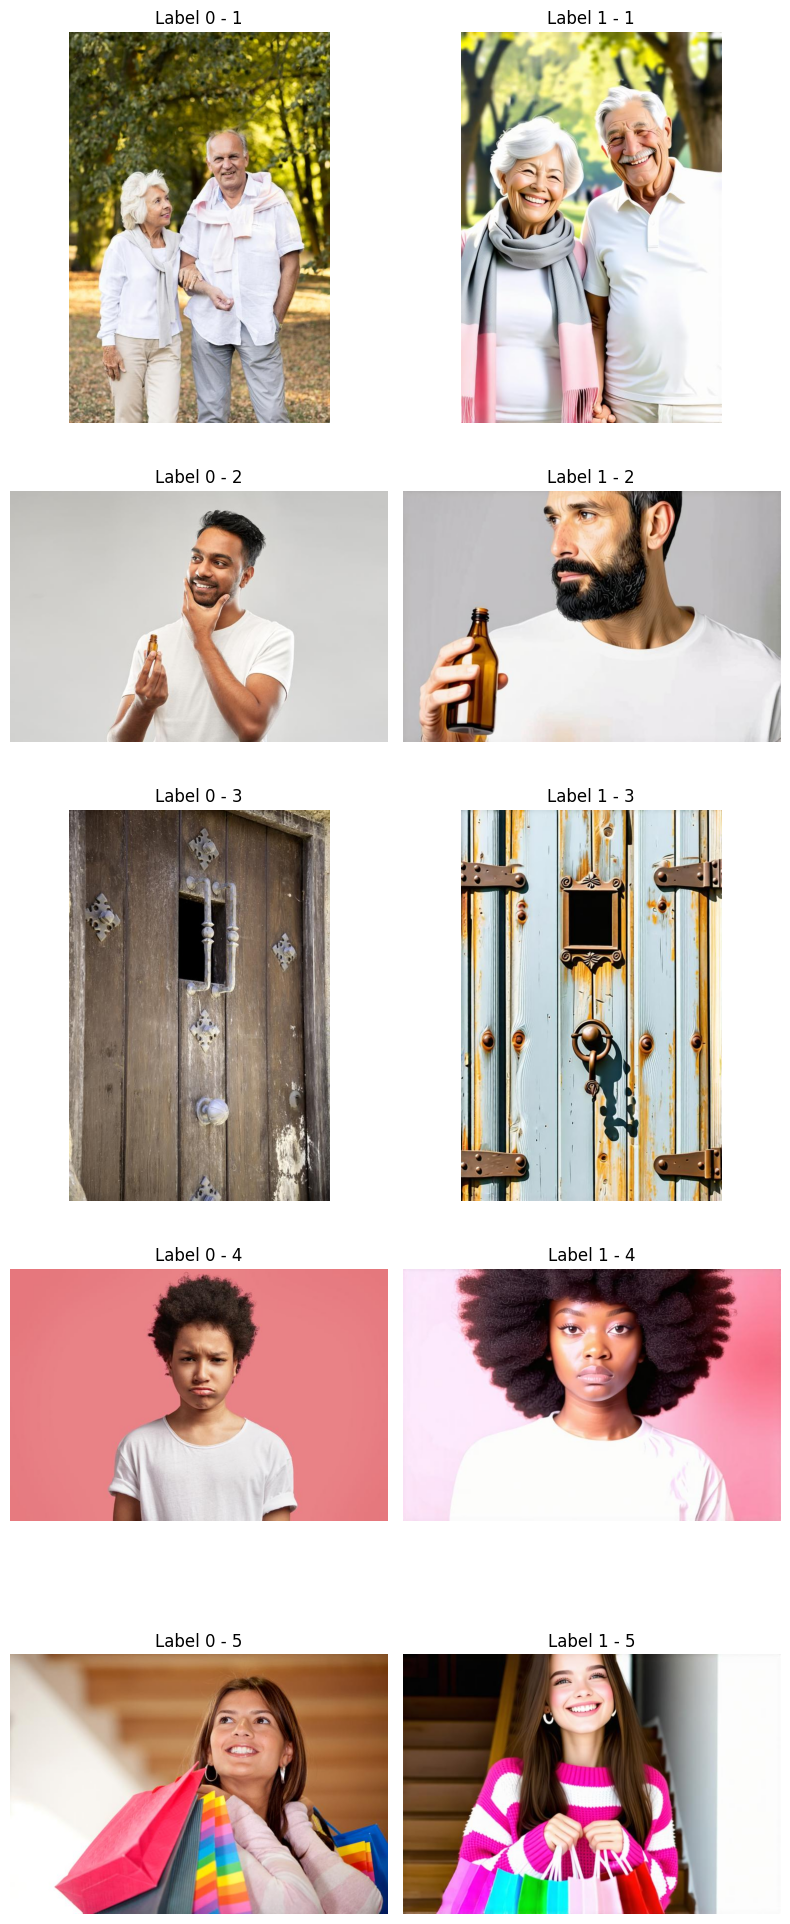

In [8]:
import matplotlib.pyplot as plt
from PIL import Image

# Take first 5 file paths from each label
files_zero = label_zero.head(5).tolist()
files_one = label_one.head(5).tolist()

# Set up the plot: 5 rows, 2 columns
fig, axes = plt.subplots(5, 2, figsize=(8, 20))

for i in range(5):
    # Label 0 images
    img0 = Image.open(files_zero[i])
    axes[i, 0].imshow(img0)
    axes[i, 0].set_title(f"Label 0 - {i+1}")
    axes[i, 0].axis("off")

    # Label 1 images
    img1 = Image.open(files_one[i])
    axes[i, 1].imshow(img1)
    axes[i, 1].set_title(f"Label 1 - {i+1}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [15]:
# pulling images from the dataset for later validation purposes
output_dir='/kaggle/working/'
from PIL import Image
import random

def image_extracter(valid_ds, output_dir, num_each_class_sample=10):
    os.makedirs(output_dir, exist_ok=True)

    # Store images by class temporarily
    class_0_images = []
    class_1_images = []

    # Iterate through the dataset and separate images by class
    for batch_imgs, batch_labels in valid_ds:
        batch_imgs_np = batch_imgs.numpy().astype(np.uint8)
        batch_labels_np = batch_labels.numpy()

        for img, lbl in zip(batch_imgs_np, batch_labels_np):
            if lbl == 0:
                class_0_images.append(img)
            else:
                class_1_images.append(img)

    # Shuffle both lists
    random.shuffle(class_0_images)
    random.shuffle(class_1_images)

    # Take only the required number
    class_0_images = class_0_images[:num_each_class_sample]
    class_1_images = class_1_images[:num_each_class_sample]

    # -------------------------
    # Save class 0 images
    # -------------------------
    zero_dir = os.path.join(output_dir, "class_zero")
    os.makedirs(zero_dir, exist_ok=True)

    for i, img in enumerate(class_0_images, start=1):
        img_pil = Image.fromarray(img)
        filename = os.path.join(zero_dir, f"zero_{i}_image.jpeg")
        img_pil.save(filename)

    # -------------------------
    # Save class 1 images
    # -------------------------
    one_dir = os.path.join(output_dir, "class_one")
    os.makedirs(one_dir, exist_ok=True)

    for i, img in enumerate(class_1_images, start=1):
        img_pil = Image.fromarray(img)
        filename = os.path.join(one_dir, f"one_{i}_image.jpeg")
        img_pil.save(filename)

    print(f"✔ Extraction complete! Saved {num_each_class_sample} images for each class.")
image_extracter(val_ds, output_dir, num_each_class_sample=10)

✔ Extraction complete! Saved 10 images for each class.


# Extras end